In [1]:
%matplotlib inline
import copy
import qutip
from qutip import Qobj
import numpy as np
import math, cmath
import matplotlib.pyplot as plt
from tqdm import tqdm

from stateobj import Physics
import utilities as use
import circuits as qc

import os

from IPython.display import Markdown, display

In [45]:
TIMESTEPS = 5000
TIMEDELTA = 1e-02
OMEGA = 0.5  # Strength of Interaction

D = 10

p = Physics(dimension=D, interaction_strength=OMEGA, interaction_time=TIMEDELTA)

th = OMEGA * TIMEDELTA
alpha = complex(1/math.sqrt(2), 0)
beta = cmath.sqrt(1 - alpha**2)
phi = np.pi/2
# Phase shifts
delta1 = 0
delta2 = -phi

In [46]:
eta = use.create_ancilla_qobj(alpha, beta, phi)
rho1 = use.create_system_qobj('coherent', n_dims=D)
rho2 = use.create_system_qobj('coherent', n_dims=D)

display(qutip.tensor(rho1, rho2))

Quantum object: dims = [[10, 10], [10, 10]], shape = (100, 100), type = oper, isherm = True
Qobj data =
[[1.35335283e-01 1.35335283e-01 9.56964964e-02 ... 3.45967741e-06
  1.21275627e-06 4.45192908e-07]
 [1.35335283e-01 1.35335283e-01 9.56964964e-02 ... 3.45967742e-06
  1.21275627e-06 4.45192908e-07]
 [9.56964964e-02 9.56964964e-02 6.76676415e-02 ... 2.44636136e-06
  8.57548183e-07 3.14798924e-07]
 ...
 [3.45967741e-06 3.45967742e-06 2.44636136e-06 ... 8.84423303e-11
  3.10025988e-11 1.13808004e-11]
 [1.21275627e-06 1.21275627e-06 8.57548183e-07 ... 3.10025988e-11
  1.08676595e-11 3.98942891e-12]
 [4.45192908e-07 4.45192908e-07 3.14798924e-07 ... 1.13808004e-11
  3.98942891e-12 1.46448672e-12]]

In [47]:
# Ancilla dephasing gate
class DephasingGate(qc.Gate):
    # Unitary evolution Matrix
    U = Qobj([[1, 0, 0], [0, 1, 0], [0, 0, cmath.exp(-1j*delta2)]])
    
    def evolve(self, system):
        return self.U * system * self.U.dag()

class MeasureGate(qc.Gate):
    def __init__(self, *args, partial_system=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.partial_system = partial_system

    def evolve(self, system):
        display(Markdown(f"{self.name.upper()} measure"))
        if self.partial_system is not None:
            traced_out_system = system.ptrace(self.partial_system)
        else:
            traced_out_system = system
        display(traced_out_system)
        return system

class FirstTimeEvolutionGate(qc.Gate):
    # This acts only on the first system
    def evolve(self, system):
        U = (1j * th * p.V1).expm()
        return U * system * U.dag()
    
class SecondTimeEvolutionGate(qc.Gate):
    def evolve(self, system):
        # This acts only on the second system
        U = (1j * th * p.V2).expm()
        return U * system * U.dag()

class TraceOutGate(qc.Gate):
    def __init__(self, *args, sys_to_keep=0, **kwargs):
        super().__init__(*args, **kwargs)
        self.sys_to_keep = sys_to_keep
        self.lanes_to_keep = [self.lanes[i] for i in range(len(sys_to_keep))]

    def evolve(self, system):
        return system.ptrace(self.sys_to_keep)

    def inject(self, step, system):
        next_step = step + 1
        for lane in self.lanes:
            series = self.controller.lanes[lane].system_evolution
            if lane not in self.lanes_to_keep:
                series[step + 1: ] = [None for _ in range(len(series) - next_step)]
            else:
                series[step + 1: ] = [system for _ in range(len(series) - next_step)]

class MasterEquationGate(qc.Gate):

    @staticmethod
    def dissipator(X: Qobj, system: Qobj):
            sandwich = X * system * X.dag()
            comm = qutip.commutator(X.dag()*X, system, kind='anti')
            return sandwich - 1/2 * comm
        
    def master_equation(self, system):
        ga = 2*alpha**2
        gb = beta**2*(1-np.cos(phi))
        # Bosonic Operators
        C = p.C
        Cp = p.Cp
        S = p.S
        Sd = p.S.dag()
        first_line = 0.5*self.dissipator(qutip.tensor(C, C) - 2*qutip.tensor(S, Sd), system) 
        first_line += self.dissipator(qutip.tensor(C, S) + qutip.tensor(S, Cp), system)
        second_line = 0.5*self.dissipator(qutip.tensor(Cp, Cp) - 2*qutip.tensor(Sd, S), system)
        second_line += self.dissipator(qutip.tensor(Cp, Sd) + qutip.tensor(Sd, C), system)
        return ga * first_line + gb * second_line
    
    def evolve(self, system):
        system_variation = self.master_equation(system)
        return system + system_variation

class ReplaceSystem(qc.Gate):
    def __init__(self, *args, new_system=None ,**kwargs):
        super().__init__(*args, **kwargs)
        self.new_system = new_system

    def evolve(self, system):
        return self.new_system

class MeasureTemperature(qc.Gate):
    def __init__(self, *args, sys_to_measure=0, result_key='temperature', **kwargs):
        super().__init__(*args, **kwargs)
        self.energy = 1
        self.system_to_measure = sys_to_measure
        self.result_key = result_key
        if result_key not in self.controller.results:
            self.controller.results[result_key] = []

    def evolve(self, system):
        system_to_measure = system.ptrace(self.system_to_measure)
        upper_element = system_to_measure.diag()[0].real
        lower_element = system_to_measure.diag()[1].real
        temperature = - self.energy / np.log(lower_element / upper_element)
        self.controller.results[self.result_key].append(temperature)
        if self.controller.logging:
            display(Markdown(f"Temperature {self.name}: {temperature}"))
        return system

In [48]:
class QuantumCircuit(qc.Circuit):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gates = [
            DephasingGate(self, [1], name='u1', control_lane=0),
            # MeasureGate(self, [1], name='mi'),
            FirstTimeEvolutionGate(self, [3, 2, 1], name='U1'),
            # MeasureGate(self, [1], name='ms', partial_system=2),
            SecondTimeEvolutionGate(self, [3, 2, 1], name='U2'),
            TraceOutGate(self, [3, 2, 1], sys_to_keep=[0, 1], name='tr'),
            MeasureTemperature(self, [2], sys_to_measure=0, name='T1', result_key='temperature S1'),
            MeasureTemperature(self, [3], sys_to_measure=1, name='T2', result_key='temperature S2'),
            ReplaceSystem(self, [1], new_system=eta, name='eta')
        ]
        self.lanes = [
            qc.Lane(self, +1, name='c1'),
            qc.Lane(self, eta, name='eta'),
            qc.Lane(self, rho1, name='rho1'),
            qc.Lane(self, rho2, name='rho2'),
        ]
a = QuantumCircuit(n_lanes=3, logging=True)
a.draw()

             1     2     3     4     5     6     7   
c1   ------- == ----------------------------------------
eta  ------- u1 -- U1 -- U2 -- tr --------------eta ----
rho1 ------------- U1 -- U2 -- tr -- T1 ----------------
rho2 ------------- U1 -- U2 -- tr -------- T2 ----------



In [52]:
a.logging = False
a.loop(50)
a.update_lane(0, -1)
a.loop(50)
a.draw()

             1     2     3     4     5     6     7   
c1   ------- == ----------------------------------------
eta  ------- u1 -- U1 -- U2 -- tr --------------eta ----
rho1 ------------- U1 -- U2 -- tr -- T1 ----------------
rho2 ------------- U1 -- U2 -- tr -------- T2 ----------



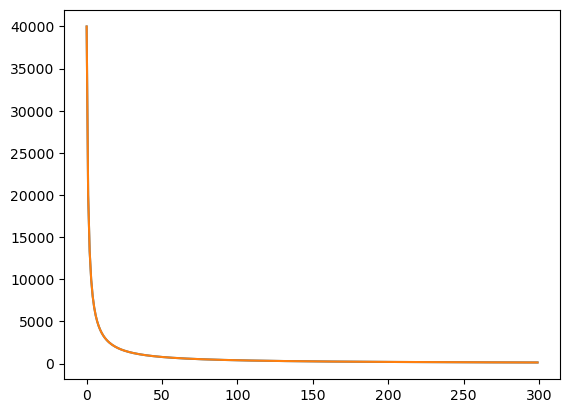

In [53]:
y=[a.results['temperature S1'], a.results['temperature S2']]
plt.plot(y[0])
plt.plot(y[1])

In [ ]:
for t, sys in enumerate(a.lanes[1].system_evolution[:]):
    print(t+1)
    display(sys)

In [ ]:
a.loop(2)

In [ ]:
qutip.tensor(0)

In [ ]:
a = [0, 0, 0, 0, 0, 0, 0]
s = 3
a[s + 1: ] = [1 for _ in range(len(a)-s-1)]
a

In [ ]:
class LittleCircuit(qc.Circuit):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gates = [
            DephasingGate(self, [1], name='u1', control_lane=0),

        ]
        self.lanes = [
            qc.Lane(self, +1, name='c1'),
            qc.Lane(self, eta, name='eta'),
            qc.Lane(self, qutip.tensor(rho1, rho2), name='rho'),
        ]

lc = LittleCircuit(logging=True)
lc.draw()

In [ ]:
lc.run()
lc.lanes[1].system_evolution